# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession

In [101]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# Tabulated head through pandas
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
# To know nulls
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [6]:
# Explore the values of some categoric columns
dfp.level.unique(), dfp.method.unique(), dfp.page.unique(), dfp.status.unique(), dfp.gender.unique(), dfp.auth.unique()

(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
        'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F', None], dtype=object),
 array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object))

#### Dropping records without userids or sessionids
Using the command `dfs = df.dropna(how = "any", subset = ["userId", "sessionId"])`

*We notice from the table above that no records with null `userId` or `SessionId`*

##### However, 
we should check for empty `userId` or `SessionId` too

In [7]:
dfp[dfp.userId == '']['userId'].count()#, dfp[dfp.sessionId =='']['sessionId'].count()

8346

In [8]:
# Using pandas
# dfp[dfp.sessionId == '']

# Using Spark commands
df.filter(df.sessionId == '').count()

0

In [9]:
# Dropping the missing User's ID rows
df = df.filter(df.userId != '')
# Check! SHOULD be 0
df.filter(df.userId == '').count()

0

In [10]:
# redifine the pandas dataframe
dfp = df.toPandas()

In [11]:
# Explore the values of some categoric columns
dfp.level.unique(), dfp.method.unique(), dfp.page.unique(), dfp.status.unique(), dfp.gender.unique(), dfp.auth.unique()

(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
        'Add Friend', 'Settings', 'Submit Upgrade', 'About',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F'], dtype=object),
 array(['Logged In', 'Cancelled'], dtype=object))

#### Note
We noticed that the when we cleaned the `userId` and `sessionId`, the `auth` column lost two values `'Logged Out'`, and `'Guest'`
and the `page` column lost some values too which are: `'Login'`, `'Register'`, and `'Submit Registration'`

This is logical, as the users without a `usedId`, are either guests or logged out users. Only guests can `Register`, or `Submit Registration`, while only logged out users can  `Login`.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [12]:
# Let's know the number of users in this dataset and the number of pages and sessions

[f'Unique {col}s: {df.select(col).dropDuplicates().count()}' for col in ('userId', 'page', 'sessionId')]

['Unique userIds: 225', 'Unique pages: 19', 'Unique sessionIds: 2312']

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [16]:
# Churn is a label for user who cancelled
# Define a flag function
flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
df = df.withColumn("churn", flag_cancelation_event("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [17]:
# Again define pandas df for better view
dfp = df.toPandas()

In [21]:
dfp.sample(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
244666,Phil Collins,Logged In,Payton,F,110,Campbell,258.48118,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1529027541000,1293,You'll Be In My Heart,200,1540634519000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39,0
82269,Maelo Ruiz,Logged In,Amberlynn,F,393,Olson,271.17669,paid,"Buffalo-Cheektowaga-Niagara Falls, NY",PUT,NextSong,1537201808000,1355,BÃÂ©same,200,1540912543000,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",75,0
243582,Boys Noize,Logged In,Payton,F,45,Campbell,267.62404,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1529027541000,1131,Oh!,200,1540149987000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39,0
124352,Zap Pow,Logged In,Emilia,F,119,House,179.95710,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1538336771000,412,This Is Reggae Music,200,1542421659000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,0
200547,Garbage,Logged In,Micah,M,130,Long,228.96281,paid,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,1347,Not My Idea,200,1540965389000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
106650,Lil Wayne,Logged In,Autumn,F,463,Martin,191.68608,paid,"Gainesville, FL",PUT,NextSong,1537749786000,1057,Phone Home,200,1540428041000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",77,0
178478,A Perfect Circle,Logged In,Erick,M,101,Brooks,288.41751,paid,"Selma, AL",PUT,NextSong,1537956751000,1046,Orestes,200,1539962558000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",58,1
40656,None,Logged In,Madelyn,F,51,Henson,NaN,paid,"Charlotte-Concord-Gastonia, NC-SC",GET,Home,1532920994000,1420,None,200,1541180394000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",113,0
112250,The Notorious B.I.G.,Logged In,Jayden,F,370,Phillips,297.22077,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1537893493000,1608,Beef (Featuring Mobb Deep) (Explicit Album Ve...,200,1541618029000,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",118,0
164016,None,Logged In,Katiana,F,0,Daniels,NaN,free,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1537812949000,378,None,200,1542967118000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",200023,0


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [33]:
# Know number of users who remain and who canceled
# by pandas
dfp.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [32]:
# by spark
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [34]:
# Exploring user status by gender

df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [35]:
# Exploring user status by paid lever

df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



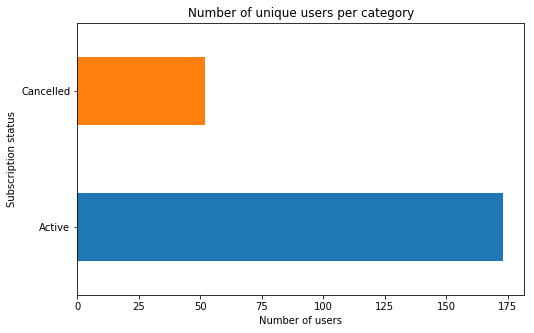

In [81]:
def plot_frequency(subset, group, labels, x_title="Number of users", y_title="Subscription status"):
    ax = dfp.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='barh', figsize=(8,5), 
                                title='Number of unique users per category');
    ax.set_xlabel(x_title);
    ax.set_yticklabels(labels, rotation=0)
    ax.set_ylabel(y_title);

# Test    
plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

We see huge number of cancelation, about 25% of the users cancelled!

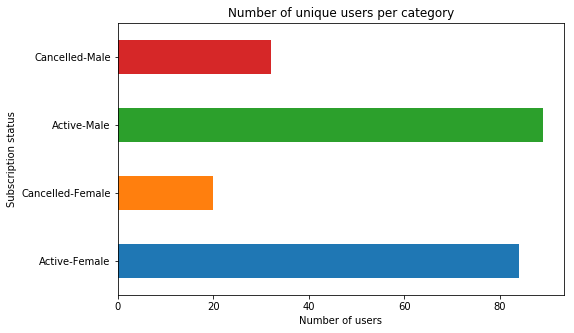

In [82]:
plot_frequency(['userId', 'gender'], 
               ['gender', 'churn'], 
               ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

The active males are more than females, and the cancelling mles are higher than females too. Seems like males tend to cancel more than females.

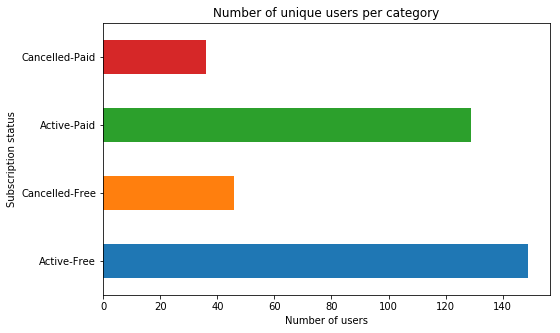

In [83]:
plot_frequency(['userId', 'level'], 
               ['level', 'churn'], 
               ['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'])

The free users are slightly more than the paid users, and the cancelled free users almost the same ratio as the cancelled paid users! it appears that the paid/free status is not influencing termination of the account.

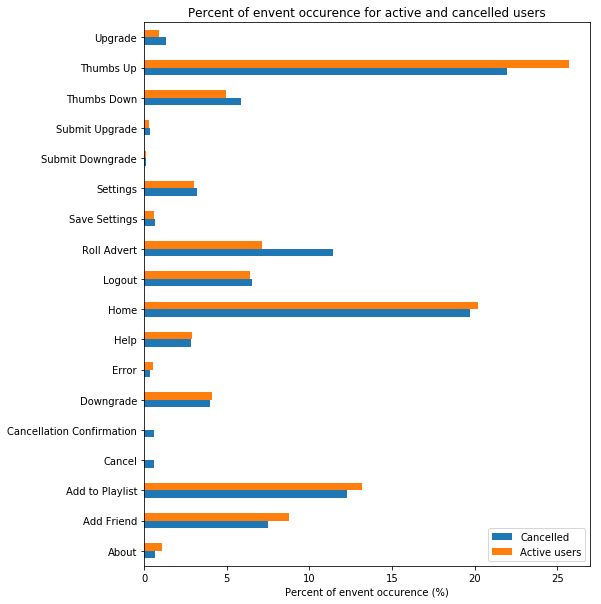

In [170]:

users_1 = dfp[dfp.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_1 = users_1 /users_1.sum()*100

users_0 = dfp[dfp.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = users_0 /users_0.sum()*100

users_df = pd.DataFrame({'Cancelled': users_1,'Active users':users_0})
ax = users_df.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Percent of envent occurence (%)')
ax.set_title('Percent of envent occurence for active and cancelled users');

It appears that the most important pages visited for cancelling users are 
`Roll Advert`, and `Thumbs Down` (directly proportion to cancelling probability), while `Thumbs Up` followed by `Add Friend` and `Add to Playlist` are good indicators for not cancelling the account.

### Time analysis

In [171]:
# Definig user functions to get hour, day, month, and weekday of cancellation

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

# Source https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [173]:
# Adding columns to the dataframe
funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday}
for label, func in funcs.items():
    df = df.withColumn(label, func(df.ts))
    print(f'Column {label} added successfully.')

Column hour added successfully.
Column day added successfully.
Column month added successfully.
Column week_day added successfully.


In [174]:
# to help in better plotting and visuals
dfp = df.toPandas()
dfp.sample(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,churn,hour,day,month,week_day
231188,None,Logged In,Joseph,M,38,Pearson,NaN,paid,"Jacksonville, NC",PUT,...,None,200,1539099680000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",200004,0,15,9,10,2
70073,Enrique Iglesias,Logged In,Lindyn,F,56,Patel,264.20200,paid,"Truckee-Grass Valley, CA",PUT,...,Hero,200,1543205766000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,300002,0,4,26,11,1
11031,Def Con Dos,Logged In,Alexi,F,19,Warren,169.92608,paid,"Spokane-Spokane Valley, WA",PUT,...,Tuno Bueno_ El Tuno Muerto,200,1538836287000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,1,14,6,10,6
244527,Joan Baez,Logged In,Payton,F,392,Campbell,183.43138,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,Virgin Mary,200,1540521052000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39,0,2,26,10,5
205910,Asobi Seksu,Logged In,Zyonna,F,40,Bird,212.50567,paid,"Columbus, GA-AL",PUT,...,Layers,200,1541504510000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,88,0,11,6,11,2


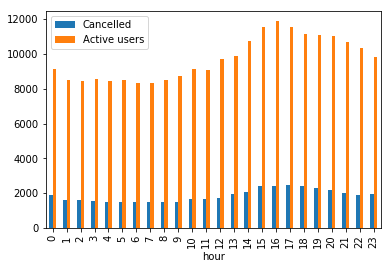

In [186]:
col = 'hour'
def get_series(churn, normalize=False):
    ser1 = dfp[dfp.churn == churn].groupby([col])['userId'].count()
    ser1.index = ser1.index.astype(int)
    if normalize:
        ser1=ser1/ser1.sum()*100
    return ser1.sort_index()

df_time = pd.DataFrame({'Cancelled': get_series(1),'Active users':get_series(0)})
df_time.plot(kind='bar');

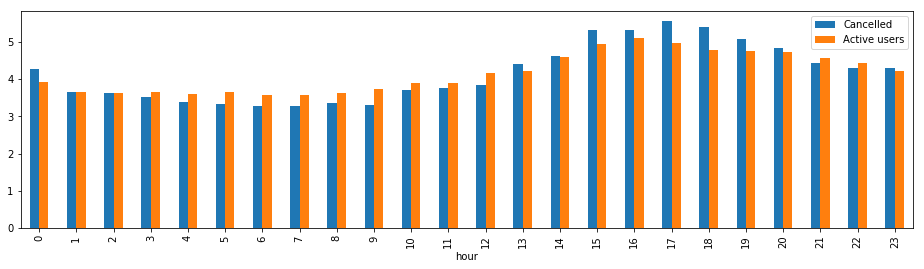

In [191]:
pd.DataFrame({'Cancelled': get_series(1, True),'Active users':get_series(0, True)}).plot(kind='bar', figsize=(16,4))

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.